# Review Sentiment Analysis

**Sentiment Analysis**: The process of using natural language processing (NLP), text analysis, and computational linguistics to determine the emotional tone behind a body of text. It’s commonly used to identify the attitude, opinion, or emotion expressed either as a category (such as positive, negative, or neutral) or on a scale (e.g. 1 to 10, 1 being bad and 10 being good).

**Honkai: Star Rail** is a 2023 free-to-play role-playing gacha video game developed and published by Hoyoverse (formerly miHoyo; c.f. Wikepedia).
Gacha game monetization is particularly controversial as players spend in-game currency (often bought with real money) to receive random virtual items or characters, similar to loot boxes or slot machines. If the monetization is too "predatory", games are bombarded with negative reviews (though this isn't the only reason for negative reviews).

**Dataset**: obtained from *https://www.kaggle.com/datasets/bagush/honkaistar-rails-mobile-game-review-google-play*
Most of the data is for Version 3 (collected over a six-month period from December 23, 2024, to June 23, 2025). My code is written for all versions, and I'll replace the dataset with a more complete version after I scrape the date from Google Playstore starting from the release date.

The particular period is quite interesting in terms of the game's lore, story delivery, powercreep and of course, Castorice's "Global Passive" which became a massive talking point in the community.

In [202]:
# Import Required Libraries

# Important
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# For Text Preprocessing
import re
import nltk

In [78]:
file_path = r"...\HSR Review.csv"
df = pd.read_csv(file_path, encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12393 entries, 0 to 12392
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reviewId  12393 non-null  object
 1   userName  12393 non-null  object
 2   content   12393 non-null  object
 3   score     12393 non-null  int64 
 4   at        12393 non-null  object
dtypes: int64(1), object(4)
memory usage: 484.2+ KB


In [80]:
#Preprocessing the dataset

# Remove duplicate reviews
df = df.drop_duplicates(subset='content')

# Remove rows where the review content is empty or just whitespace
df = df[df['content'].notnull() & (df['content'].str.strip() != '')]

# Reset index after dropping rows
df = df.reset_index(drop=True)

# A check for any emaining missing data: if YES, remove them
#print(df.isnull().sum())
#df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11693 entries, 0 to 11692
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reviewId  11693 non-null  object
 1   userName  11693 non-null  object
 2   content   11693 non-null  object
 3   score     11693 non-null  int64 
 4   at        11693 non-null  object
dtypes: int64(1), object(4)
memory usage: 456.9+ KB


In [82]:
# Convert 'at' column to "date_time"

df['date_time'] = pd.to_datetime(df['at'])

# Extract Components
# Useful for Review Bombing and Temporal Trend (banner or patch releases) Analysis
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['weekday'] = df['date_time'].dt.day_name()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11693 entries, 0 to 11692
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   reviewId   11693 non-null  object        
 1   userName   11693 non-null  object        
 2   content    11693 non-null  object        
 3   score      11693 non-null  int64         
 4   at         11693 non-null  object        
 5   date_time  11693 non-null  datetime64[ns]
 6   year       11693 non-null  int32         
 7   month      11693 non-null  int32         
 8   day        11693 non-null  int32         
 9   weekday    11693 non-null  object        
dtypes: datetime64[ns](1), int32(3), int64(1), object(5)
memory usage: 776.6+ KB


**Note:**
*Lemmatization* and *stemming* are techniques used in text preprocessing to reduce words to their base or root form. Used in sentiment analysis to treat similar words as one.
*Lemmatization* converts a word to its base (dictionary) form (lemma) using context (like part of speech), e.g., studies > study.
*Stemming* removes suffixes to reduce a word to its root form, often not a real word, e.g., studies > studi.
While *Lemmatization* is slower (uses a dictionary to compare), it's usually more accurate.

In [85]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary resources (up-to-date)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Initialize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Cleaning function
def clean_review(text):
    # converts to lowercase
    text = text.lower()
    
    # removes punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # tokenize
    tokens = word_tokenize(text)
    
    # remove stopwords and lemmatize
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(cleaned)

# Cleaned dataset
df['cleaned_content'] = df['content'].apply(clean_review)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11693 entries, 0 to 11692
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   reviewId         11693 non-null  object        
 1   userName         11693 non-null  object        
 2   content          11693 non-null  object        
 3   score            11693 non-null  int64         
 4   at               11693 non-null  object        
 5   date_time        11693 non-null  datetime64[ns]
 6   year             11693 non-null  int32         
 7   month            11693 non-null  int32         
 8   day              11693 non-null  int32         
 9   weekday          11693 non-null  object        
 10  cleaned_content  11693 non-null  object        
dtypes: datetime64[ns](1), int32(3), int64(1), object(6)
memory usage: 868.0+ KB


In [87]:
# Adding Version data
# Version and their release dates were taken from https://honkai-star-rail.fandom.com/wiki/Version (Accessed: 2025-07-11)

# Patch version information
version_data = {
    'HSR_Ver': [
        '1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6',
        '2.0', '2.1', '2.2', '2.3', '2.4', '2.5', '2.6', '2.7',
        '3.0', '3.1', '3.2', '3.3', '3.4'
    ],
    'Ver_Release_Date': [
        '2023-04-26', '2023-06-07', '2023-07-19', '2023-08-30', '2023-10-11',
        '2023-11-15', '2023-12-27', '2024-02-06', '2024-03-27', '2024-05-08',
        '2024-06-19', '2024-07-31', '2024-09-10', '2024-10-23', '2024-12-04',
        '2025-01-15', '2025-02-26', '2025-04-09', '2025-05-21', '2025-07-02'
    ]
}

# DataFrame of versions
ver_df = pd.DataFrame(version_data)
ver_df['Ver_Release_Date'] = pd.to_datetime(ver_df['Ver_Release_Date'])

ver_df = ver_df.sort_values(by='Ver_Release_Date').reset_index(drop=True) #sorted by date

# Assign a version to each review (based on date_time)
def assign_version(review_date):
    for i in range(len(ver_df) - 1):
        if ver_df.loc[i, 'Ver_Release_Date'] <= review_date < ver_df.loc[i + 1, 'Ver_Release_Date']:
            return ver_df.loc[i, 'HSR_Ver']
    return ver_df.loc[len(ver_df) - 1, 'HSR_Ver']  # Latest version fallback

df['version'] = df['date_time'].apply(assign_version)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11693 entries, 0 to 11692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   reviewId         11693 non-null  object        
 1   userName         11693 non-null  object        
 2   content          11693 non-null  object        
 3   score            11693 non-null  int64         
 4   at               11693 non-null  object        
 5   date_time        11693 non-null  datetime64[ns]
 6   year             11693 non-null  int32         
 7   month            11693 non-null  int32         
 8   day              11693 non-null  int32         
 9   weekday          11693 non-null  object        
 10  cleaned_content  11693 non-null  object        
 11  version          11693 non-null  object        
dtypes: datetime64[ns](1), int32(3), int64(1), object(7)
memory usage: 959.3+ KB


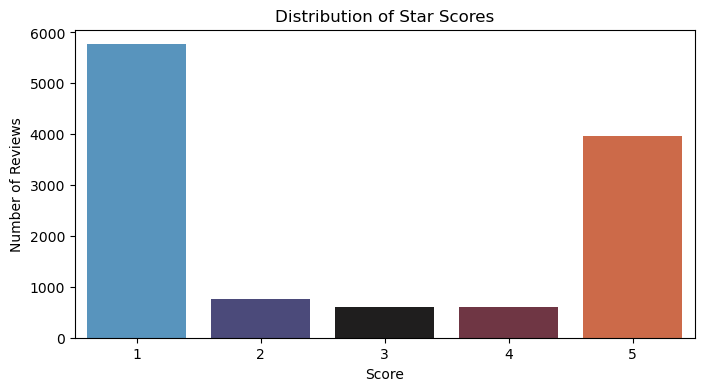

In [91]:
# Exploratory Data Analysis

# Frequency of Ratings (Stars)
plt.figure(figsize=(8, 4))
sns.countplot(x='score', data=df, palette='icefire')
plt.title("Distribution of Star Scores")
plt.xlabel("Score")
plt.ylabel("Number of Reviews")
plt.show()


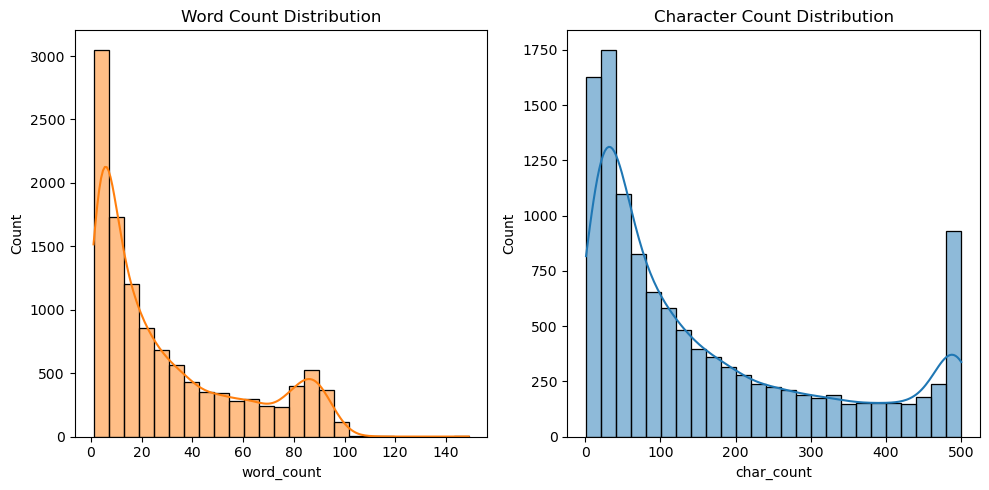

In [93]:
# Word and character Count Histograms

df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['content'].apply(lambda x: len(str(x)))

warnings.filterwarnings("ignore", message=".*use_inf_as_na.*")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(df['word_count'], bins=25, ax=axs[0], kde=True, color='#ff7f0e')
axs[0].set_title('Word Count Distribution')

sns.histplot(df['char_count'], bins=25, ax=axs[1], kde=True, color='#1f77b4')
axs[1].set_title('Character Count Distribution')

plt.tight_layout()
plt.show()

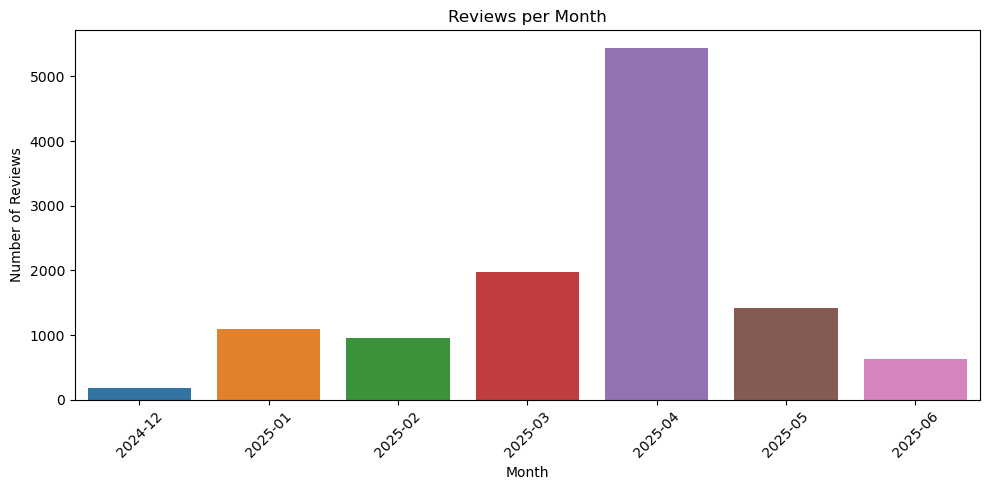

In [97]:
# Monthly Review trends

df['month_year'] = df['date_time'].dt.to_period('M').astype(str)

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='month_year', order=sorted(df['month_year'].unique()))
plt.xticks(rotation=45)
plt.title("Reviews per Month")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

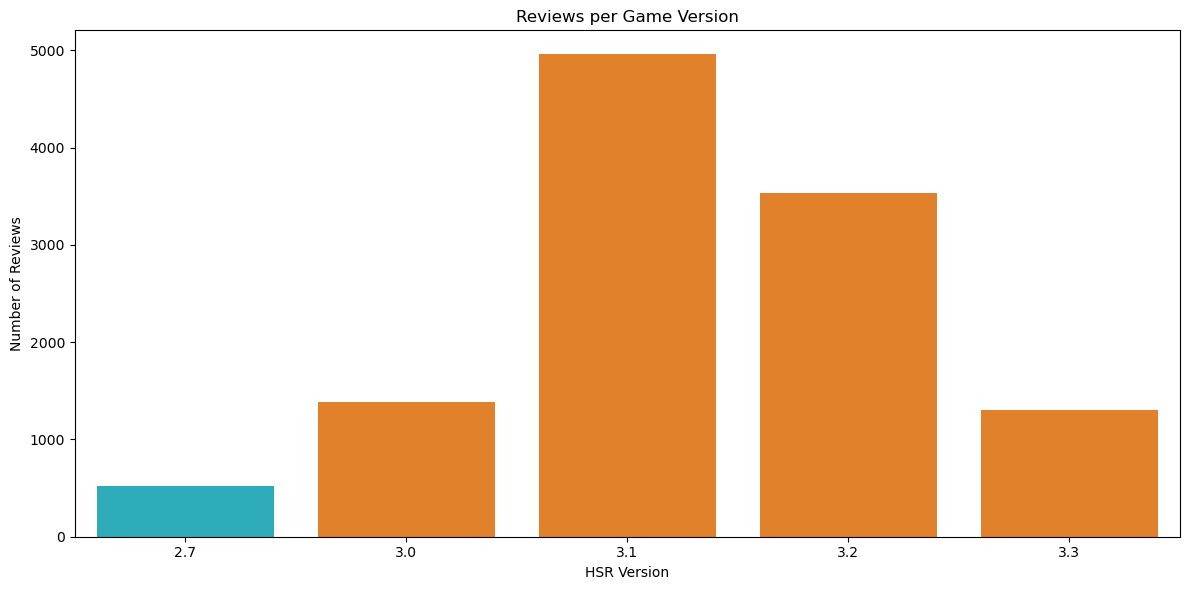

In [19]:
# Reviews per Version

def version_palette(ver):
    if ver.startswith('1.'):
        return '#1f77b4'  # Blue
    elif ver.startswith('2.'):
        return '#17becf'  # Teal
    elif ver.startswith('3.'):
        return '#ff7f0e'  # Golden-orange
    return 'gray'
# The colors are chosen to stay in theme with the versions

# Assign patch cycle colors
colors = [version_palette(ver) for ver in sorted(df['version'].unique())]

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='version', order=sorted(df['version'].unique()), palette=colors)
plt.title("Reviews per Game Version")
plt.xlabel("HSR Version")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

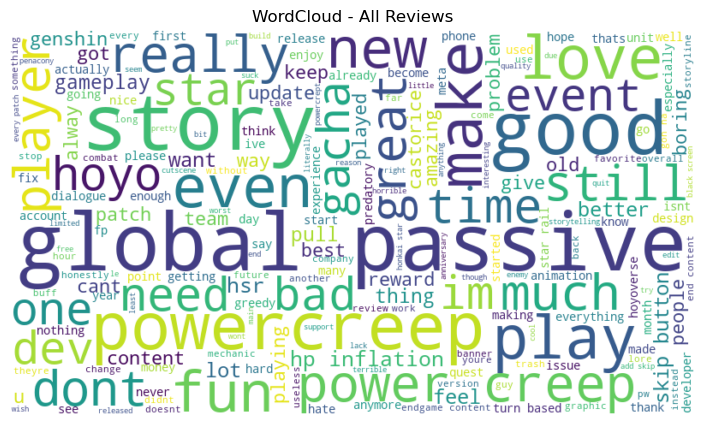

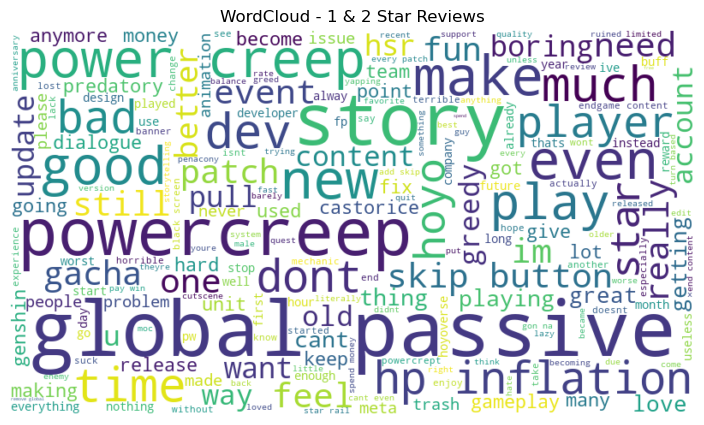

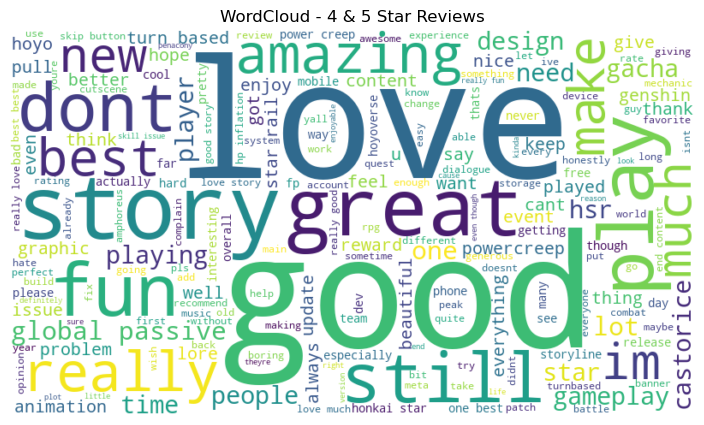

In [104]:
# Word Cloud

from wordcloud import WordCloud

# Note: Usually, top 3 to 5 words are sentiment neutral. In this case "game" and "character".
# Remove "game" and "character" from cleaned_content column
df['cleaned_content'] = df['cleaned_content'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in {'game', 'character'}])
)

def generate_wordcloud(text, title):
    wc = WordCloud(width=800, height=450, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# All reviews
generate_wordcloud(df['cleaned_content'], 'WordCloud - All Reviews')

# 1-2 star reviews
generate_wordcloud(df[df['score'] <= 2]['cleaned_content'], 'WordCloud - 1 & 2 Star Reviews')

# 4-5 star reviews
generate_wordcloud(df[df['score'] >= 4]['cleaned_content'], 'WordCloud - 4 & 5 Star Reviews')


**Note:**
Since there is no standard orthographic convention for representing compunds like powercreep, we see across the data set use of hyphenated or spaced variants, "power-creep" and "power creep". This shouldn't count as separate words and can be enforced in the analysis.

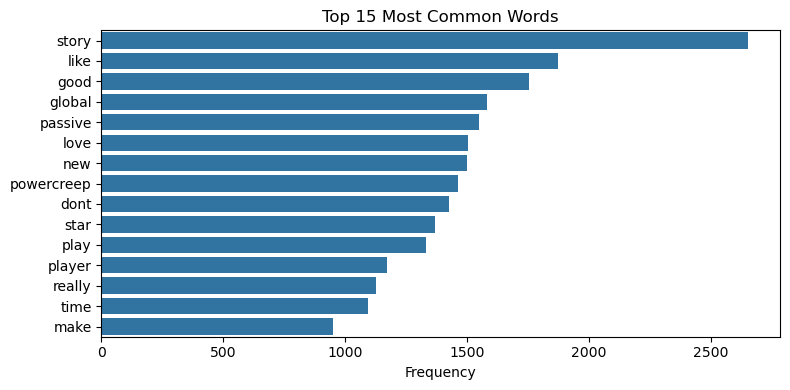

In [107]:
# Top Words

from sklearn.feature_extraction.text import CountVectorizer

# Unigram frequency
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['cleaned_content'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False).head(15)

# Plot top unigrams
plt.figure(figsize=(8, 4))
sns.barplot(x=word_freq.values, y=word_freq.index, color='#1f77b4')
plt.title("Top 15 Most Common Words")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


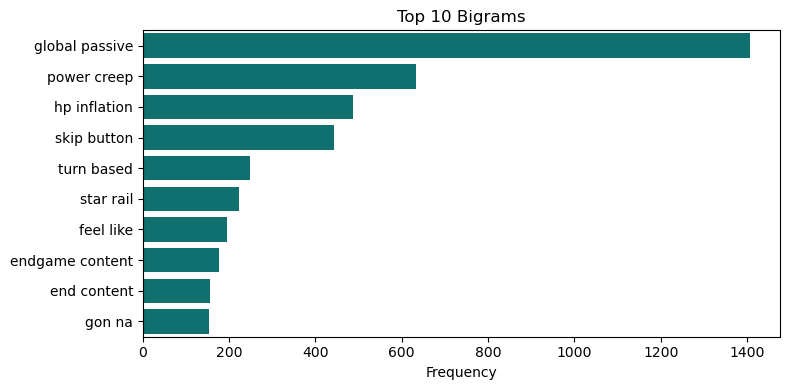

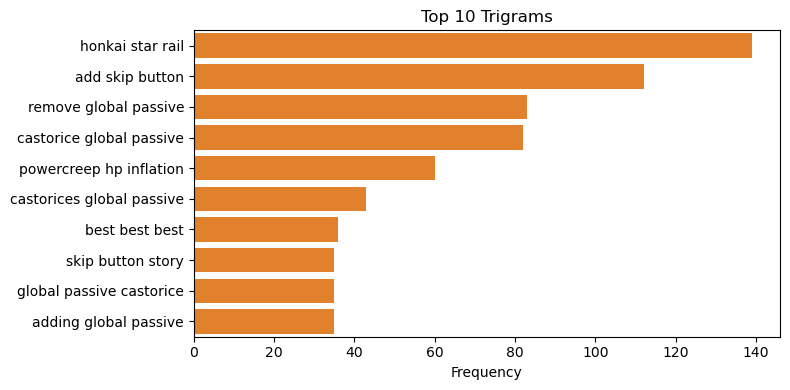

In [108]:
# Bigrams
bigram_vec = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_bi = bigram_vec.fit_transform(df['cleaned_content'])
bigram_freq = pd.DataFrame(X_bi.toarray(), columns=bigram_vec.get_feature_names_out()).sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x=bigram_freq.values, y=bigram_freq.index, color='teal')
plt.title("Top 10 Bigrams")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

# Trigrams
trigram_vec = CountVectorizer(ngram_range=(3, 3), stop_words='english')
X_tri = trigram_vec.fit_transform(df['cleaned_content'])
trigram_freq = pd.DataFrame(X_tri.toarray(), columns=trigram_vec.get_feature_names_out()).sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x=trigram_freq.values, y=trigram_freq.index, color='#ff7f0e')
plt.title("Top 10 Trigrams")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

In [112]:
# Sentiment Analysis and Classification

# Rule-based sentiment Analysis using VADER (or TextBlob)
# VADER better for short reviews, TextBlob for larger (not suitable for social media)

from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon') 

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Apply VADER to each cleaned review
df['vader_scores'] = df['cleaned_content'].apply(lambda x: vader.polarity_scores(x)['compound'])

# Classify based on compound score
def vader_sentiment(score):
    if score > 0.5:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_sentiment'] = df['vader_scores'].apply(vader_sentiment)


**Note:**
Genrally VADER sentimet compund score ranges from -1 (most negative) to +1 (most positive). Here we customize it to be *positive* if > 0.5, *negative* if < 0, and *neutral* otherwise. 

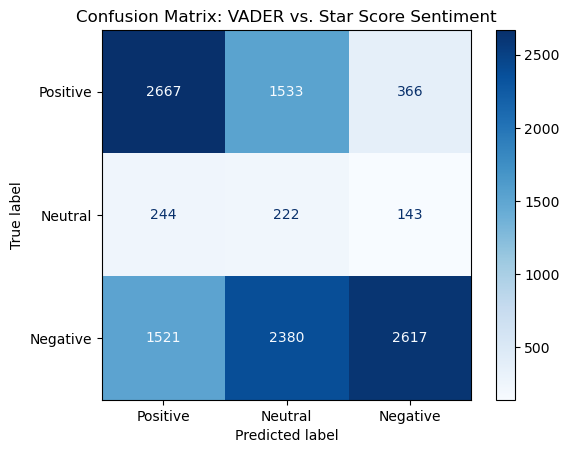

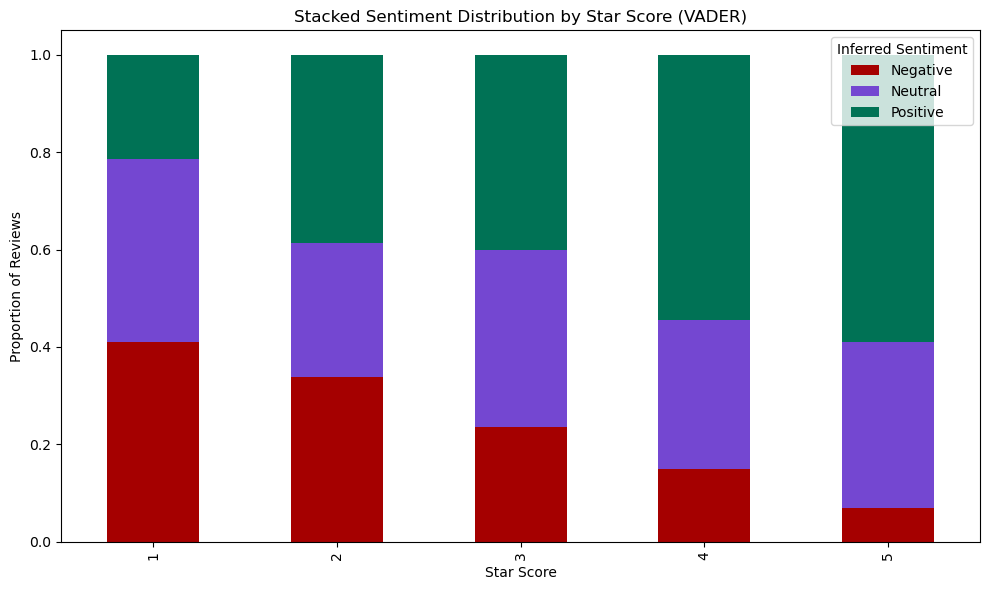

In [118]:
# Compare Sentiment vs Score (Star Rating)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert star rating to sentiment label
def score_to_sentiment(star):
    if star <= 2:
        return 'Negative'
    elif star == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['score_sentiment'] = df['score'].apply(score_to_sentiment)

# Confusion matrix (VADER vs Score)
cm = confusion_matrix(df['score_sentiment'], df['vader_sentiment'], labels=['Positive', 'Neutral', 'Negative'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Neutral', 'Negative'])

disp.plot(cmap='Blues')
plt.title("Confusion Matrix: VADER vs. Star Score Sentiment")
plt.show()

# Stacked Bar Chart
sentiment_by_score = pd.crosstab(df['score'], df['vader_sentiment'], normalize='index')

sentiment_by_score.plot(kind='bar', stacked=True, figsize=(10, 6),
                        color=['#a50000', '#7447d1', '#007255'])  # c.f. https://www.colorhexa.com/ 
plt.title("Stacked Sentiment Distribution by Star Score (VADER)")
plt.xlabel("Star Score")
plt.ylabel("Proportion of Reviews")
plt.legend(title='Inferred Sentiment')
plt.tight_layout()
plt.show()

In [120]:
# Spearman's Correlation

from scipy.stats import spearmanr

# Spearman correlation between review star score and sentiment polarity
vader_corr, _ = spearmanr(df['score'], df['vader_scores'])
print(f"Spearman correlation (Star Score vs VADER polarity): {vader_corr:.3f}")

Spearman correlation (Star Score vs VADER polarity): 0.418


In [124]:
# Advanced Learning Models

# Feature Engineering
# Text Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorizer (unigrams, bigrams)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

# Fit-transform the cleaned content
X = tfidf.fit_transform(df['cleaned_content'])

# Target for classification
y_class = df['score_sentiment']

# Target for regression
y_reg = df['score']


In [166]:
# Modelling (multiple models)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Train and Test Split (for classification)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.1, random_state=86, stratify=y_class)


Report (Model 1: Logistic Regression):

              precision    recall  f1-score   support

    Negative       0.79      0.91      0.85       652
     Neutral       0.00      0.00      0.00        61
    Positive       0.81      0.75      0.78       457

    accuracy                           0.80      1170
   macro avg       0.54      0.55      0.54      1170
weighted avg       0.76      0.80      0.78      1170



C:\Users\30719\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\30719\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\30719\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


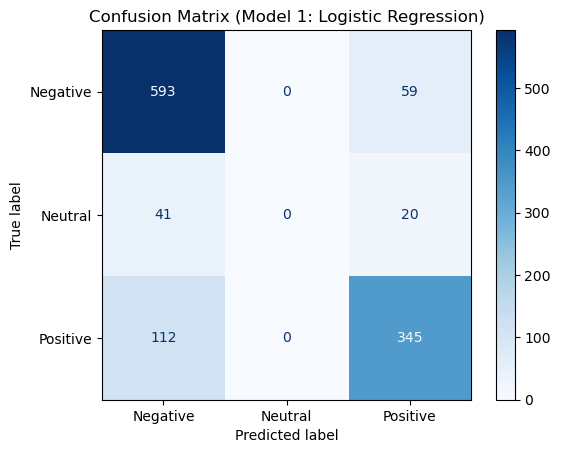

In [168]:
# Model 1: Logistic Regression

lr_model = LogisticRegression(max_iter=666)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Report (Model 1: Logistic Regression):\n")
print(classification_report(y_test, y_pred_lr))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap = 'Blues')
plt.title("Confusion Matrix (Model 1: Logistic Regression)")
plt.show()


Report (Model 2: Naive Bayes):

              precision    recall  f1-score   support

    Negative       0.78      0.92      0.85       652
     Neutral       0.00      0.00      0.00        61
    Positive       0.83      0.73      0.77       457

    accuracy                           0.80      1170
   macro avg       0.54      0.55      0.54      1170
weighted avg       0.76      0.80      0.77      1170



C:\Users\30719\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\30719\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\30719\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


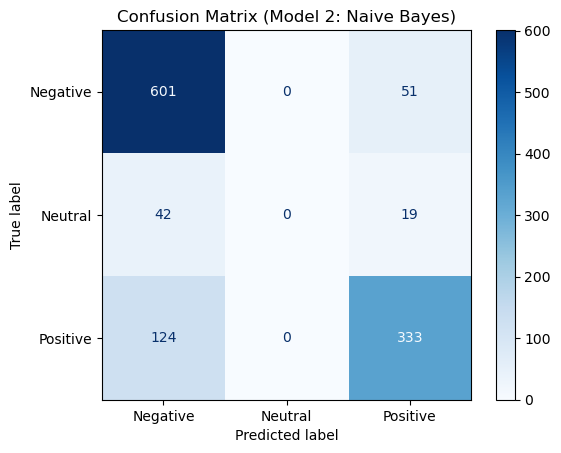

In [169]:
# Model 2: Naive Bayes

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Report (Model 2: Naive Bayes):\n")
print(classification_report(y_test, y_pred_nb))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, cmap = 'Blues')
plt.title("Confusion Matrix (Model 2: Naive Bayes)")
plt.show()


Report (Model 3: Random Forest):

              precision    recall  f1-score   support

    Negative       0.79      0.87      0.83       652
     Neutral       0.00      0.00      0.00        61
    Positive       0.76      0.75      0.76       457

    accuracy                           0.78      1170
   macro avg       0.52      0.54      0.53      1170
weighted avg       0.74      0.78      0.76      1170



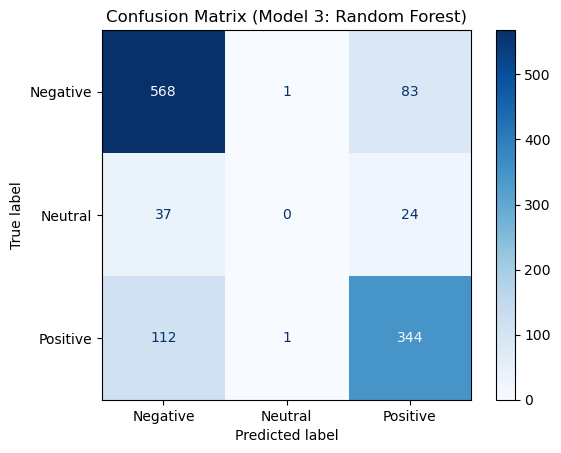

In [170]:
# Model 3: Random Forest

rf_model = RandomForestClassifier(n_estimators=69, random_state=86)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Report (Model 3: Random Forest):\n")
print(classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap = 'Blues')
plt.title("Confusion Matrix (Model 3: Random Forest)")
plt.show()


Report (Model 4: GBoost):

              precision    recall  f1-score   support

    Negative       0.73      0.94      0.82       652
     Neutral       0.33      0.02      0.03        61
    Positive       0.84      0.59      0.69       457

    accuracy                           0.76      1170
   macro avg       0.63      0.52      0.52      1170
weighted avg       0.75      0.76      0.73      1170



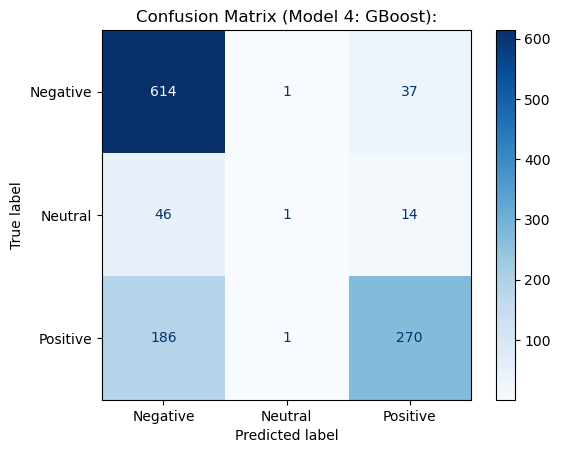

In [171]:
# Model 4: GBoost

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("Report (Model 4: GBoost):\n")
print(classification_report(y_test, y_pred_gb))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, cmap = 'Blues')
plt.title("Confusion Matrix (Model 4: GBoost):")
plt.show()


**Note:**
- *Accuracy* is the proportion of all reviews where the predicted sentiment matches the true sentiment. It measures the overall corrctness of the model.
- *Precision* is the measure of how many predicted labels were actually correct, e.g., a value of Negative 0.72 implies of all reviews predicted as Negative, 72% were truly Negative.
- *Recall* measures how many actual labels were correctly predicted, e.g., a value of Postive 0.58 implies the model correctly identified 58% of true Positive reviews.
- *F1-score* is the harmonic mean of precision and recall that is accepted as a balance between Precision and Recall.

*Weighted Average* of the above scores takes class size imbalance into account and provides evaluation that is more reflective of the true performance.

In [175]:
# Regression on Score (Star Rating)

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.10, random_state=86)

# Train regressor
reg_model = GradientBoostingRegressor()
reg_model.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_model.predict(X_test_reg)

# Evaluation
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_reg):.2f}")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_reg):.2f}")
print(f"R^2 Score: {r2_score(y_test_reg, y_pred_reg):.2f}")

# Very low R^2 score implies a bad fit

MAE: 1.25
MSE: 2.06
R^2 Score: 0.39


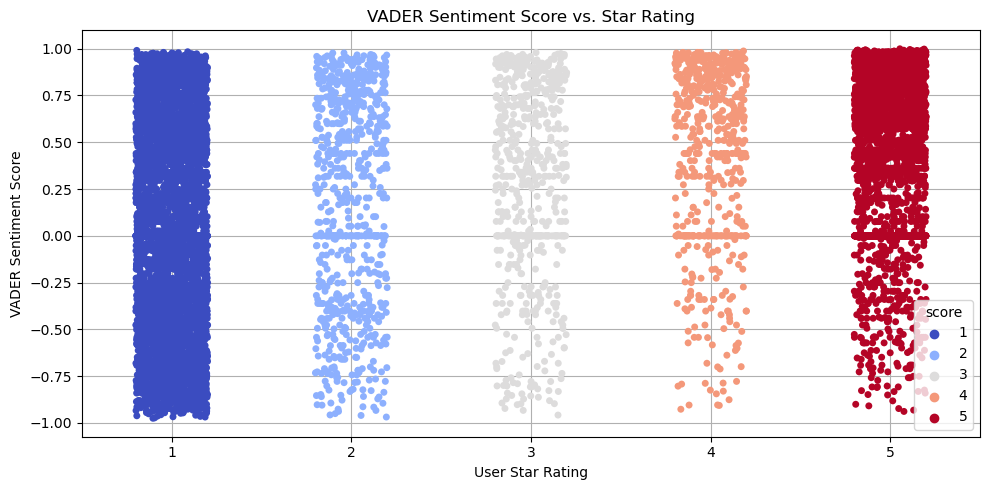

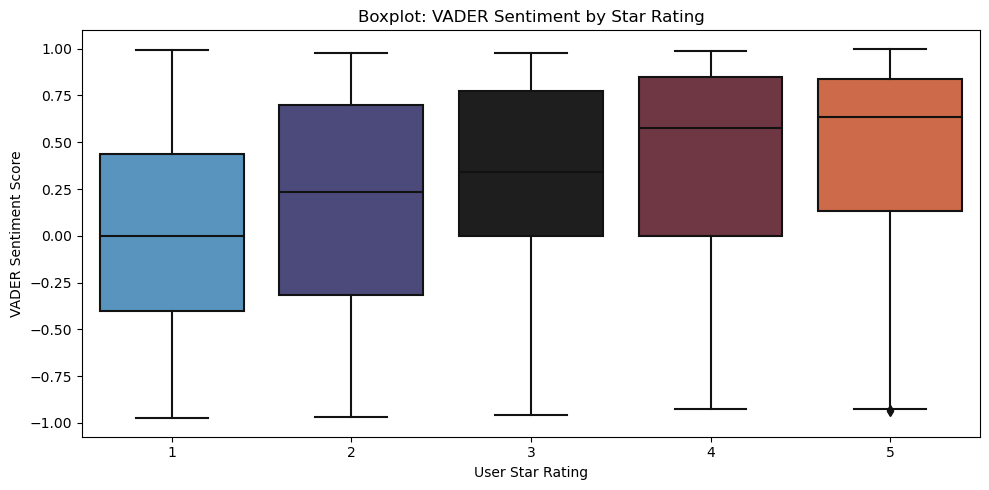

In [176]:
# Further Visuals and Analysis

#Sentiment Score vs Star Rating

# Strip plot
plt.figure(figsize=(10, 5))
sns.stripplot(x='score', y='vader_scores', data=df, jitter=0.2, hue='score', palette='coolwarm', dodge=False)
plt.title("VADER Sentiment Score vs. Star Rating")
plt.xlabel("User Star Rating")
plt.ylabel("VADER Sentiment Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x='score', y='vader_scores', data=df, palette='icefire')
plt.title("Boxplot: VADER Sentiment by Star Rating")
plt.xlabel("User Star Rating")
plt.ylabel("VADER Sentiment Score")
plt.grid(False)
plt.tight_layout()
plt.show()

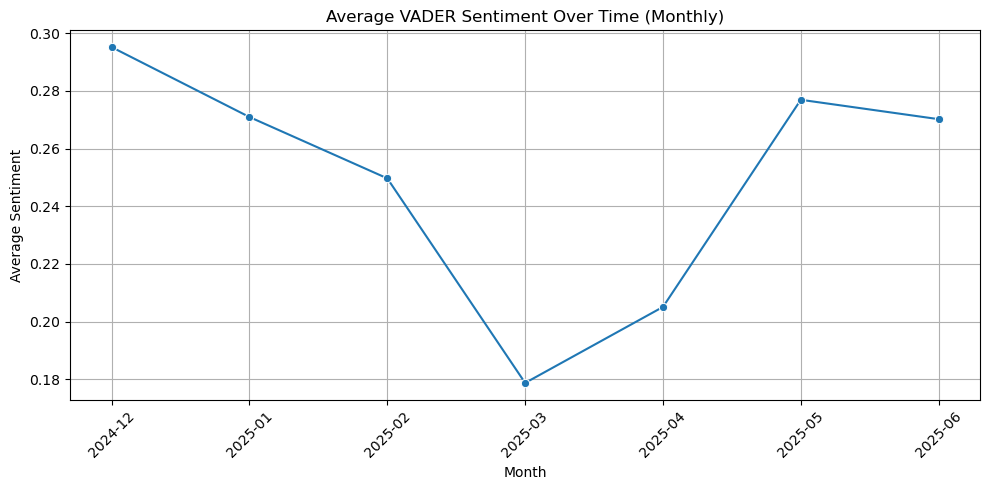

In [177]:
# Temporal Analysis

# Monthly trends

# Conversion to months
df['month'] = df['date_time'].dt.to_period('M').astype(str)

# Group by month
monthly_sentiment = df.groupby('month')['vader_scores'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_sentiment, x='month', y='vader_scores', marker='o')
plt.xticks(rotation=45)
plt.title("Average VADER Sentiment Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Average Sentiment")
plt.grid(True)
plt.tight_layout()
plt.show()


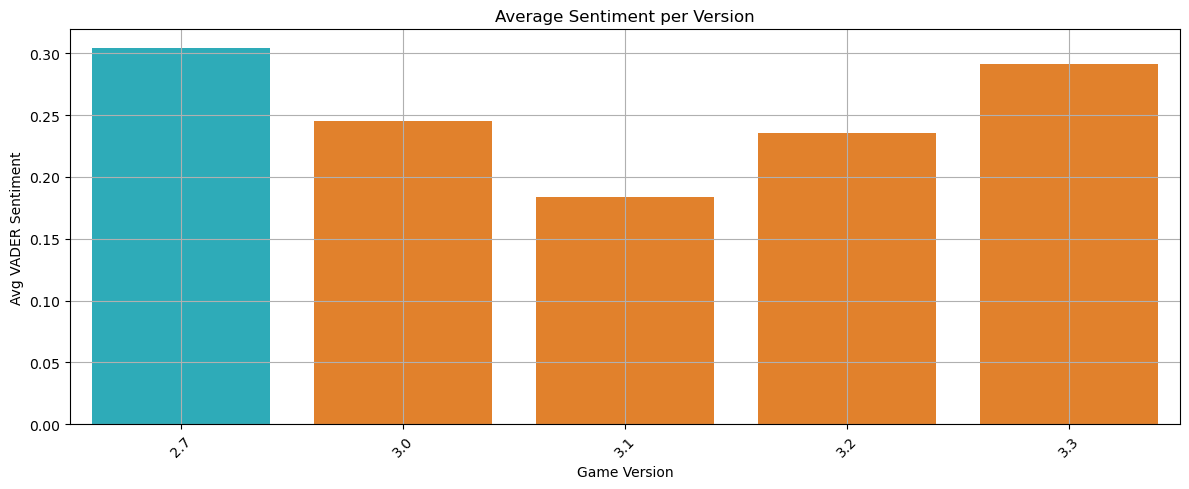

In [183]:
# Version Trends

# Group by version
version_sentiment = df.groupby('version')['vader_scores'].mean().reset_index()

# Color code patches by versions
def version_color(ver):
    if ver.startswith('1.'):
        return '#1f77b4'  # blue
    elif ver.startswith('2.'):
        return '#17becf'  # teal
    elif ver.startswith('3.'):
        return '#ff7f0e'  # golden-orange
    return 'gray'

colors = [version_color(ver) for ver in version_sentiment['version']]

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(data=version_sentiment, x='version', y='vader_scores', palette=colors)
plt.title("Average Sentiment per Version")
plt.xlabel("Game Version")
plt.ylabel("Avg VADER Sentiment")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

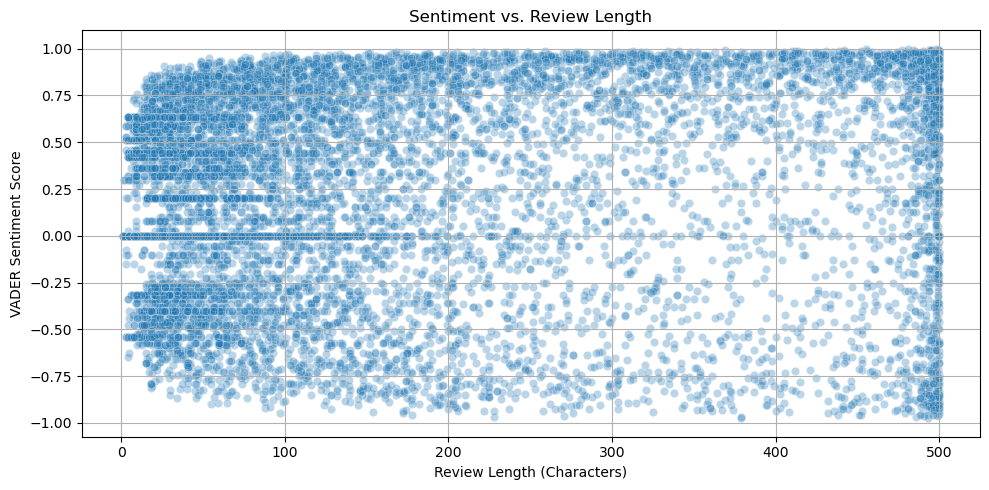

In [185]:
# Review Length vs Sentiment
# People usually assume longer reviews means a negative review

# Extract Review length (in characters)
df['review_length'] = df['content'].apply(len) # use "content" instead of "content cleaned"

# Plot sentiment vs length
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='review_length', y='vader_scores', alpha=0.3)
plt.title("Sentiment vs. Review Length")
plt.xlabel("Review Length (Characters)")
plt.ylabel("VADER Sentiment Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# There appears to be no general relation between long reviews and negative reviews.

In [54]:
# More Adavanced Analysis

# Latent Dirichlet Allocation: extract topics from extreme reviews: 1-star and 5-star

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Filter 1-star and 5-star reviews
df_1star = df[df['score'] == 1]
df_5star = df[df['score'] == 5]

# Create bag-of-words for 1-star
cv_1 = CountVectorizer(max_df=0.95, min_df=10, stop_words='english')
X_1 = cv_1.fit_transform(df_1star['cleaned_content'])

# Apply LDA
lda_1 = LatentDirichletAllocation(n_components=3, random_state=42)
lda_1.fit(X_1)

# Display topics
def display_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print("")

print("Top Topics in 1-Star Reviews:")
display_topics(lda_1, cv_1.get_feature_names_out())

# Repeat for 5-star
cv_5 = CountVectorizer(max_df=0.95, min_df=10, stop_words='english')
X_5 = cv_5.fit_transform(df_5star['cleaned_content'])

lda_5 = LatentDirichletAllocation(n_components=3, random_state=42)
lda_5.fit(X_5)

print("Top Topics in 5-Star Reviews:")
display_topics(lda_5, cv_5.get_feature_names_out())

Top Topics in 1-Star Reviews:
Topic 1:
powercreep, story, like, gacha, money, time, event, good, bad, really

Topic 2:
global, passive, power, hp, creep, inflation, powercreep, castorice, new, story

Topic 3:
dont, new, star, story, player, play, skip, like, time, content

Top Topics in 5-Star Reviews:
Topic 1:
story, love, amazing, fun, good, design, really, great, turn, gameplay

Topic 2:
good, best, play, star, really, like, great, genshin, dont, im

Topic 3:
love, dont, like, global, people, passive, review, star, new, castorice



**Note:**

Negative reviews focus on enemy scaling (hp), story (too much dialogue felt "boring" and people started asking for "skip button"), and of course powercreep, especially Castorice's global passive.
Positive reviews are mostly praise for character designs, story lore and narrative, and gameplay. Even the meme "*Genshin could never*" made it.

Even though Castorice's "global passive" was met with mostly negative reception, it was such a huge talking point, that even positive reviews would mention it.

C:\Users\30719\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


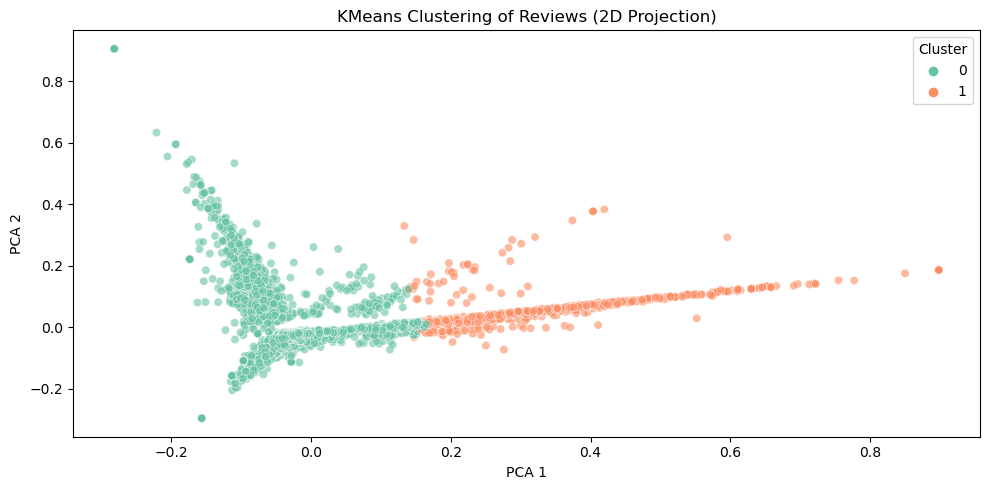

In [190]:
# Cluster Reviews by text

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Reduce dimensionality with PCA for 2D plotting (optional)
pca = PCA(n_components=2, random_state=86)
X_pca = pca.fit_transform(X.toarray())

# Cluster
kmeans = KMeans(n_clusters=2, random_state=86)
df['cluster'] = kmeans.fit_predict(X)

# Plot clusters in 2D
plt.figure(figsize = (10, 5))
sns.scatterplot(x = X_pca[:, 0], y = X_pca[:, 1], hue = df['cluster'], palette = 'Set2', alpha = 0.6)
plt.title("KMeans Clustering of Reviews (2D Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [198]:
# Inspect keywords from each cluster

# Function to get top N words per cluster
def get_top_keywords(data, cluster_col, text_col, N_top=10):
    top_words = {}
    vectorizer = CountVectorizer(stop_words='english')
    
    for label in sorted(data[cluster_col].unique()):
        # Join all cleaned content in this cluster
        cluster_text = data[data[cluster_col] == label][text_col].values
        joined = ' '.join(cluster_text)
        
        # Fit-transform
        X_cluster = vectorizer.fit_transform([joined])
        freqs = zip(vectorizer.get_feature_names_out(), X_cluster.toarray()[0])
        
        # Sort and store top words
        sorted_freqs = sorted(freqs, key=lambda x: x[1], reverse=True)[:N_top]
        top_words[label] = sorted_freqs

    return top_words

# Apply to your df
top_keywords = get_top_keywords(df, 'cluster', 'cleaned_content', N_top=10)

# Display
for cluster, words in top_keywords.items():
    print(f"\n Cluster {cluster} Top Words:")
    for word, freq in words:
        print(f"{word}: {freq}")

for i in sorted(df['cluster'].unique()):
    print(f"\n Sample from Cluster {i}:")
    print(df[df['cluster'] == i]['content'].iloc[21][:300])  # Selects the 21st content of cluster i and displays first 300 characters


 Cluster 0 Top Words:
story: 2596
like: 1769
good: 1702
love: 1446
new: 1433
powercreep: 1339
dont: 1307
star: 1297
play: 1286
player: 1096

 Cluster 1 Top Words:
passive: 1038
global: 1028
castorice: 154
remove: 135
powercreep: 125
dont: 121
like: 103
bad: 92
make: 76
player: 75

 Sample from Cluster 0:
really good

 Sample from Cluster 1:
Too much powercreep and at this point other characters with global passive will be the trend, castorice may get powercreeped sooner or later, the new characters will all be powercreeped in the 3rd anniversary just watch.


In [204]:
#  Multinomial ANOVA: Do sentiment scores differ by star rating?

from scipy.stats import kruskal

# Group sentiment scores by star rating
groups = [df[df['score'] == i]['vader_scores'] for i in range(1, 6)]

# Perform Kruskal-Wallis test
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H-test statistic: {stat:.3f}")
print(f"P-value: {p:.4f}")

# p-value < 0.05 implies significant difference in sentiment score distributions across ratings

Kruskal-Wallis H-test statistic: 2076.474
P-value: 0.0000
